In [1]:
!nvidia-smi

Mon Nov  1 15:28:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P8    13W /  N/A |   1211MiB /  6144MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
from tensorflow.keras.models import Model

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
BATCH_SIZE = 64

In [4]:
ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, batch_size = -1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [5]:
images, labels = ds['train']

In [6]:
del ds
#del images
#del labels

In [11]:
model  = tf.keras.models.load_model('CNN_weights/CNN_1.h5')
model.compile()

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)      

In [13]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
            # construct our gradient model by supplying (1) the inputs
            # to our pre-trained model, (2) the output of the (presumably)
            # final 4D layer in the network, and (3) the output of the
            # softmax activations from the model
            gradModel = Model(
                inputs=[self.model.inputs],
                outputs=[self.model.get_layer(self.layerName).output,
                    self.model.output])
        
        # record operations for automatic differentiation
            with tf.GradientTape() as tape:
                # cast the image tensor to a float-32 data type, pass the
                # image through the gradient model, and grab the loss
                # associated with the specific class index
                inputs = tf.cast(image, tf.float32)
                (convOutputs, predictions) = gradModel(inputs)
                loss = predictions[:, self.classIdx]
            # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)
            
            
            # compute the guided gradients
            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            # the convolution and guided gradients have a batch dimension
            # (which we don't need) so let's grab the volume itself and
            # discard the batch
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]
            
            # compute the average of the gradient values, and using them
            # as weights, compute the ponderation of the filters with
            # respect to the weights
            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
            
            # grab the spatial dimensions of the input image and resize
            # the output class activation map to match the input image
            # dimensions
            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
            # return the resulting heatmap to the calling function
            return heatmap
        
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

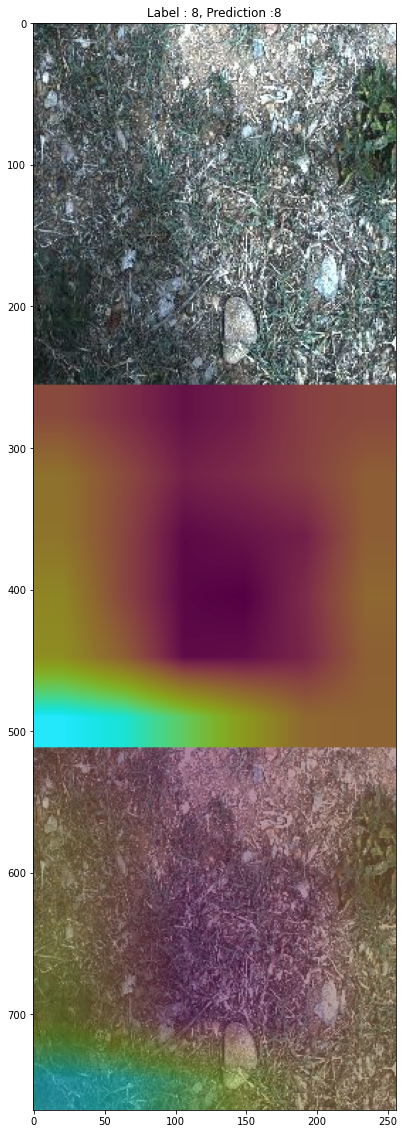

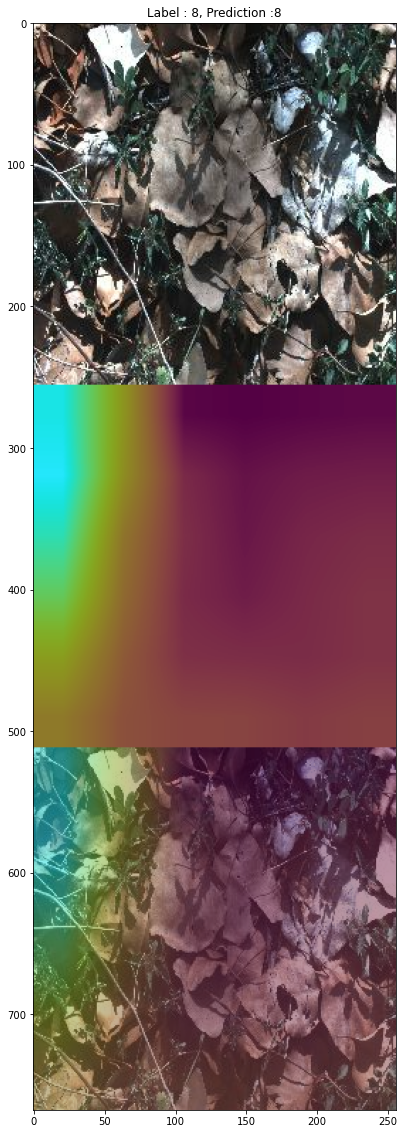

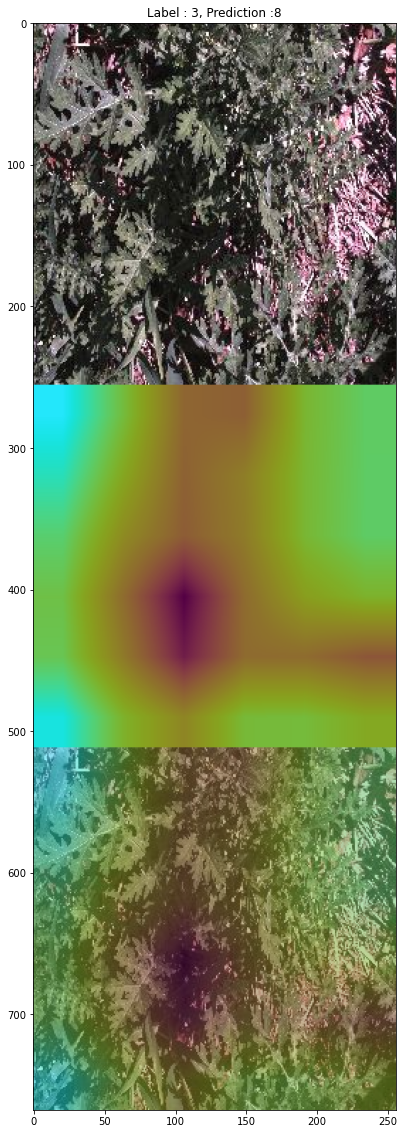

In [100]:
for i in range(3):
    ind = np.random.randint(0, len(labels))
    image = images[ind].numpy()
    im = np.expand_dims(image, axis = 0)
    im.shape

    pred = model.predict(im)
    y = np.argmax(pred)

    cam = GradCAM(model, y)
    heatmap = cam.compute_heatmap(im)

    (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha = 0.5)


    output = np.vstack([image, heatmap, output])

    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(1,2,1)
    plt.imshow(output, cmap = 'viridis')
    ax.set_title(f"Label : {labels[ind]}, Prediction :{y}")